# Nouvelle section

In [1]:
%tensorflow_version 2.x


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os

print(f"TensorFlow version = {tf.__version__}\n")

#seed for reproducing results
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "biceps",
    "shoulders",
    "still"
]

NAMES = [
         "me",
         "mama",
         "tata"
]

SAMPLES_PER_GESTURE = 300

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)
print(ONE_HOT_ENCODED_GESTURES)

TensorFlow version = 2.4.1

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [3]:

inputs = []
outputs = []


In [4]:

# read each csv file 
for name in NAMES:
  for gesture_index in range(NUM_GESTURES-1): #standing still is treated in another cell since this was independent of the person
    gesture = GESTURES[gesture_index]
    print(f"Processing index {gesture_index} for gesture '{gesture}'.")
    
    output = ONE_HOT_ENCODED_GESTURES[gesture_index]
    
    df = pd.read_csv(name + "_" + gesture + ".csv", skip_blank_lines=True, delimiter=',').dropna()

    # calculate the number of gestures
    num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
    
    for i in range(num_recordings):
      data = []
      for j in range(SAMPLES_PER_GESTURE):
        index = i * SAMPLES_PER_GESTURE + j


        if index + i % 300 != 0 or index + i == 0:
          #print(df.iloc[index])
          data.append([
              df['aX'][index+i],
              df['aY'][index+i], 
              df['aZ'][index+i], 
              df['gX'][index+i], 
              df['gY'][index+i], 
              df['gZ'][index+i] 
          ])
    
      inputs.append(np.array(data))
      outputs.append(output)
print("Done reading gestures dependent on person")

Processing index 0 for gesture 'biceps'.
Processing index 1 for gesture 'shoulders'.
Processing index 0 for gesture 'biceps'.
Processing index 1 for gesture 'shoulders'.
Processing index 0 for gesture 'biceps'.
Processing index 1 for gesture 'shoulders'.
Done reading gestures dependent on person


In [5]:

gesture = "still"

output = ONE_HOT_ENCODED_GESTURES[2]
still_gesture_read = 0

df = pd.read_csv(gesture + ".csv", skip_blank_lines=True, delimiter=',').dropna()
still_gesture_read = 1
# calculate the number of gesture recordings in the file
num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

for i in range(num_recordings):
  data = []
  for j in range(SAMPLES_PER_GESTURE):
    index = i * SAMPLES_PER_GESTURE + j

    if index + i % 300 != 0 or index + i == 0: #because of the new line between each 300 sample entry
      #print(df.iloc[index])
          data.append([
              df['aX'][index+i],
              df['aY'][index+i], 
              df['aZ'][index+i], 
              df['gX'][index+i], 
              df['gY'][index+i], 
              df['gZ'][index+i] 
          ])

  inputs.append(np.array(data))
  outputs.append(output)
# convert inputs and outputs to np.arrays one inputs were processed
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Whole data read")

	There are 54 recordings of the still gesture.
Whole data read


In [6]:
def generate_random_data(data_points, label=np.array([0., 0., 1.])): #data points represent how many samples of random moves to generate
  random_data = []
  labels = np.array([label for _ in range(data_points)])
  for _ in range(data_points):
    acc_random = np.random.uniform(low=-4, high=4, size=[SAMPLES_PER_GESTURE, 3])
    gyro_random = np.random.uniform(low=-2000, high=2000, size=[SAMPLES_PER_GESTURE, 3])
    random_data.append(np.concatenate([acc_random, gyro_random], axis=1)) #concatenate gyro and acc to have whole entry
  
  return np.array(random_data), labels

In [7]:
def augment_data_with_noise(data, labels): #add noise to data
  noisy_data = [] 
  noisy_labels = []
  for i in range(data.shape[0]):
    acc_noisy_data = np.zeros_like(data[0])
    gyro_noisy_data = np.zeros_like(data[0])
    for _ in range(10): #10 new entries from each given entry
      acc_noise = np.random.normal(loc = 0, scale = 1, size=[300,3])
      gyro_noise = np.random.normal(loc = 0, scale = 2, size=[300,3]) #different scale because gyro values are between -2k -> +2k
      acc_noisy_data = inputs[i, :, 0:3] + acc_noise #add noise acc
      gyro_noisy_data = inputs[i, :, 3:] + gyro_noise #add noise gyro
      noisy_data.append(np.concatenate([acc_noisy_data, gyro_noisy_data], axis=1)) #concatenate new entry 
      noisy_labels.append(labels[i]) #label stayed the same, just noise added

  noisy_data = np.array(noisy_data)
  noisy_labels = np.array(noisy_labels)

  return (noisy_data, noisy_labels)

def augment_data_amplify(data, labels, ratios = [(2, 3), (5, 6), (8,9), (9, 8), (6, 5), (3, 2)]):
  amplified_data = []
  amplified_labels = []
  for i in range(data.shape[0]):
    for ratio in ratios:
      amplified_data.append((data[i]*ratio[0])/ratio[1]) #amplify or deamplify each movement
      amplified_labels.append(labels[i])
  amplified_data = np.array(amplified_data)
  amplified_labels = np.array(amplified_labels)

  return amplified_data, amplified_labels

In [8]:
noisy_data, noisy_labels = augment_data_with_noise(inputs, outputs)
amplified_data, amplified_labels = augment_data_amplify(inputs, outputs)
random_data, random_labels = generate_random_data(500)

new_inputs = np.concatenate([inputs, noisy_data, amplified_data, random_data], axis = 0) #add to dataset
new_outputs = np.concatenate([outputs, noisy_labels, amplified_labels, random_labels], axis = 0) #add to dataset


In [9]:
#check inputs and outputs shapes
print(new_inputs.shape)
print(new_outputs.shape)

(7028, 300, 6)
(7028, 3)


In [10]:
print(np.sum(new_outputs, axis=0)) #number of entries per gesture type

[3213. 2397. 1418.]


In [11]:
all_data_train = new_inputs.reshape((new_inputs.shape[0], 300, 6, 1)) #reshaping for tf

In [12]:
print(all_data_train.shape)

(7028, 300, 6, 1)


In [13]:
def define_model():
  model = tf.keras.Sequential([ #input shape = (batch, 300, 6, 1)
  tf.keras.layers.Conv2D(8, (8, 6), name="Conv1", padding="same",activation="relu",\
  input_shape=(SAMPLES_PER_GESTURE, 6, 1)),
  tf.keras.layers.MaxPool2D((3, 3), name="MAXPool1"),
  tf.keras.layers.Dropout(0.1), 
  tf.keras.layers.Conv2D(8, (4, 1), padding="same", activation="relu", name="Conv2"),
  tf.keras.layers.MaxPool2D((3, 1), padding="same", name="MAXPool2"),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Flatten(name="Flatten"),
  tf.keras.layers.Dense(16, activation="relu", name="Dense1"),
  tf.keras.layers.Dense(3, activation="softmax", name="Output")
  ])

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model


In [14]:
import datetime
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [21]:
from sklearn.model_selection import StratifiedKFold
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, new_Y, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = StratifiedKFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX, new_Y):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=5, batch_size=64, validation_data=(testX, testY), verbose=1, callbacks=[tensorboard_callback])
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

In [22]:
def revert_one_hot(data):
  new_data = np.array([0 for i in range(len(data))])
  for i in range(len(data)):
    for j in range(len(GESTURES)):
      if data[i][j] == 1:
        new_data[i] = j

  return new_data

new_data_train_Y = revert_one_hot(new_outputs)

In [23]:
model = define_model()
evaluate_model(all_data_train, new_outputs, new_data_train_Y) #CV

Epoch 1/5
88/88 [==============================] - 2s 13ms/step - loss: 5.7337 - accuracy: 0.6748 - val_loss: 0.0745 - val_accuracy: 0.9737
Epoch 2/5
88/88 [==============================] - 0s 5ms/step - loss: 0.1357 - accuracy: 0.9703 - val_loss: 0.0157 - val_accuracy: 0.9936
Epoch 3/5
88/88 [==============================] - 0s 5ms/step - loss: 0.0438 - accuracy: 0.9865 - val_loss: 0.0094 - val_accuracy: 0.9979
Epoch 4/5
88/88 [==============================] - 0s 5ms/step - loss: 0.0199 - accuracy: 0.9907 - val_loss: 0.0080 - val_accuracy: 0.9979
Epoch 5/5
88/88 [==============================] - 0s 5ms/step - loss: 0.0090 - accuracy: 0.9976 - val_loss: 0.0053 - val_accuracy: 0.9993
> 99.929
Epoch 1/5
88/88 [==============================] - 2s 13ms/step - loss: 8.7806 - accuracy: 0.5367 - val_loss: 0.1995 - val_accuracy: 0.9474
Epoch 2/5
88/88 [==============================] - 0s 5ms/step - loss: 0.2875 - accuracy: 0.9399 - val_loss: 0.0850 - val_accuracy: 0.9844
Epoch 3/5
88/88 

([0.9992887377738953,
  0.9971550703048706,
  0.9907538890838623,
  1.0,
  0.9928825497627258],
  <tensorflow.python.keras.callbacks.History at 0x7f079e2d32d0>])

In [24]:
model = define_model()
model.fit(all_data_train, new_outputs, epochs = 10, batch_size = 64, verbose=1)

Epoch 1/10
110/110 [==============================] - 1s 5ms/step - loss: 5.2880 - accuracy: 0.6305
Epoch 2/10
110/110 [==============================] - 0s 4ms/step - loss: 0.2300 - accuracy: 0.9633
Epoch 3/10
110/110 [==============================] - 0s 4ms/step - loss: 0.0324 - accuracy: 0.9878
Epoch 4/10
110/110 [==============================] - 0s 4ms/step - loss: 0.0241 - accuracy: 0.9901
Epoch 5/10
110/110 [==============================] - 0s 4ms/step - loss: 0.0178 - accuracy: 0.9951
Epoch 6/10
110/110 [==============================] - 0s 3ms/step - loss: 0.0083 - accuracy: 0.9973
Epoch 7/10
110/110 [==============================] - 0s 4ms/step - loss: 0.0097 - accuracy: 0.9972
Epoch 8/10
110/110 [==============================] - 0s 3ms/step - loss: 0.0062 - accuracy: 0.9989
Epoch 9/10
110/110 [==============================] - 0s 4ms/step - loss: 0.0069 - accuracy: 0.9990
Epoch 10/10
110/110 [==============================] - 0s 4ms/step - loss: 0.0035 - accuracy: 0.9997

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gym_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gym_model.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: /tmp/tmpjywyip9v/assets
Model is 40852 bytes


In [26]:
! apt-get -qq install xxd


!echo "const unsigned char gym_model_data[] = {" > /content/model.h
!cat gym_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Selecting previously unselected package xxd.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.4_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.4) ...
Setting up xxd (2:8.0.1453-1ubuntu1.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Header file, model.h, is 251,965 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


Data visualization

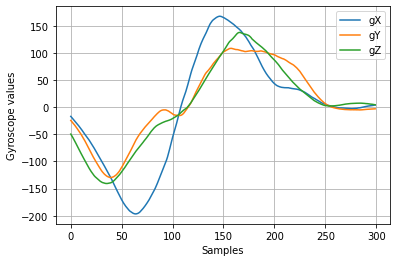

In [30]:
data = pd.read_csv("me_biceps.csv")
  
# converting column data to list
ax = data['aX'].tolist()
ay = data['aY'].tolist()
az = data['aZ'].tolist()
gx = data['gX'].tolist()
gy = data['gY'].tolist()
gz = data['gZ'].tolist()  

xr = range(300)
plt.plot(xr, gx[:300])
plt.plot(xr, gy[:300])
plt.plot(xr, gz[:300])
plt.legend(["gX", "gY", "gZ"])
plt.grid()
plt.ylabel("Gyroscope values")
plt.xlabel("Samples")
plt.savefig("gyro_biceps.png")
plt.show()


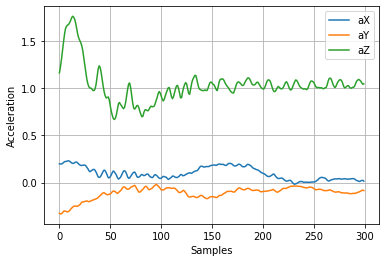

In [31]:
data = pd.read_csv("me_shoulders.csv")
  
# converting column data to list
ax = data['aX'].tolist()
ay = data['aY'].tolist()
az = data['aZ'].tolist()
gx = data['gX'].tolist()
gy = data['gY'].tolist()
gz = data['gZ'].tolist()  

# printing list data
xr = range(300)
plt.plot(xr, ax[:300])
plt.plot(xr, ay[:300])
plt.plot(xr, az[:300])
plt.legend(["aX", "aY", "aZ"])
plt.grid()
plt.ylabel("Acceleration")
plt.xlabel("Samples")
plt.savefig("acc_shoulders.png")
plt.show()

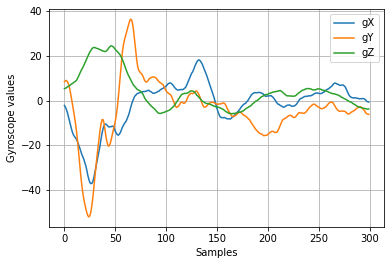

In [32]:
plt.plot(xr, gx[:300])
plt.plot(xr, gy[:300])
plt.plot(xr, gz[:300])
plt.legend(["gX", "gY", "gZ"])
plt.grid()
plt.ylabel("Gyroscope values")
plt.xlabel("Samples")
plt.savefig("gyro_shoulders.png")
plt.show()